# Clustering Practice

#### https://github.com/machinalis/satimg/blob/master/object_based_image_analysis.ipynb

In [32]:
%matplotlib inline

import numpy as np
import os
import scipy

from matplotlib import pyplot as plt
from matplotlib import colors
from osgeo import gdal
from skimage import exposure
from skimage.segmentation import quickshift, felzenszwalb
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

RASTER_DATA_FILE = "../../../capstone_data/landsat_images/LANDSAT_LC8_L1T_8DAY_RAW_20130618.tif"
TRAIN_DATA_PATH = "cluster_practice/data/train/"
TEST_DATA_PATH = "cluster_practice/data/test/"

In [33]:

def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1):
    """Rasterize the given vector (wrapper for gdal.RasterizeLayer)."""
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize all the vectors in the given directory into a single image."""
    labeled_pixels = np.zeros((rows, cols))
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        ds = None
    return labeled_pixels

In [34]:

raster_dataset = gdal.Open(RASTER_DATA_FILE, gdal.GA_ReadOnly)
geo_transform = raster_dataset.GetGeoTransform()
proj = raster_dataset.GetProjectionRef()
n_bands = raster_dataset.RasterCount
bands_data = []
for b in range(1, n_bands+1):
    band = raster_dataset.GetRasterBand(b)
    bands_data.append(band.ReadAsArray())

bands_data = np.dstack(b for b in bands_data)

In [35]:
img = exposure.rescale_intensity(bands_data)
rgb_img = np.dstack([img[:, :, 3], img[:, :, 2], img[:, :, 1]])

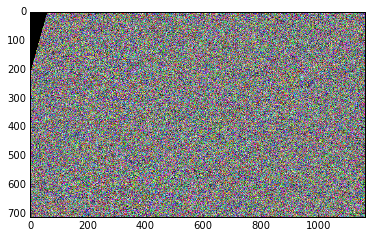

In [36]:
plt.figure()
plt.imshow(rgb_img)

In [37]:
segments_quick = quickshift(img, kernel_size=7, max_dist=3, ratio=0.35, convert2lab=False)
n_segments = len(np.unique(segments_quick))
print(n_segments)

7014


In [48]:
quickshift?

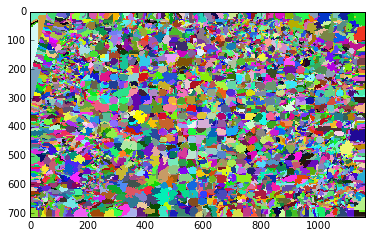

In [38]:
cmap = colors.ListedColormap(np.random.rand(n_segments, 3))
plt.figure()
plt.imshow(segments_quick, interpolation='none', cmap=cmap)

In [49]:
felzenszwalb?

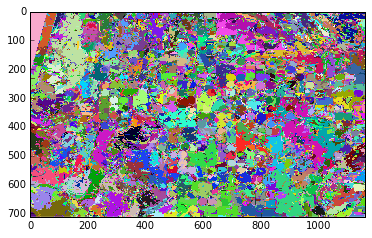

In [51]:
band_segmentation = []
for i in range(n_bands):
    band_segmentation.append(felzenszwalb(img[:, :, i], scale=85, sigma=0.25, min_size=9)) #was originally sigma=0.25

const = [b.max() + 1 for b in band_segmentation]
segmentation = band_segmentation[0]
for i, s in enumerate(band_segmentation[1:]):
    segmentation += s * np.prod(const[:i+1])

_, labels = np.unique(segmentation, return_inverse=True)
segments_felz = labels.reshape(img.shape[:2])

cmap = colors.ListedColormap(np.random.rand(len(np.unique(segments_felz)), 3))
plt.figure()
plt.imshow(segments_felz, interpolation='none', cmap=cmap)

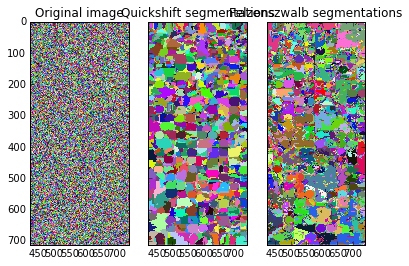

In [52]:
n_segments = max(len(np.unique(s)) for s in [segments_quick, segments_felz])
cmap = colors.ListedColormap(np.random.rand(n_segments, 3))
#SHOW_IMAGES:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.imshow(rgb_img, interpolation='none')
ax1.set_title('Original image')
ax2.imshow(segments_quick, interpolation='none', cmap=cmap)
ax2.set_title('Quickshift segmentations')
ax3.imshow(segments_felz, interpolation='none', cmap=cmap)
ax3.set_title('Felzenszwalb segmentations')
plt.show()

In [53]:
# We choose the quick segmentation
segments = segments_felz
segment_ids = np.unique(segments)
print("Felzenszwalb segmentation. %i segments." % len(segment_ids))

Felzenszwalb segmentation. 19121 segments.


In [54]:
img.shape

(713, 1163, 12)

In [55]:

rows, cols, n_bands = img.shape
files = [f for f in os.listdir(TRAIN_DATA_PATH) if f.endswith('.shp')]
classes_labels = [f.split('.')[0] for f in files]
shapefiles = [os.path.join(TRAIN_DATA_PATH, f) for f in files if f.endswith('.shp')]
print(shapefiles)

['cluster_practice/data/train/A.shp', 'cluster_practice/data/train/B.shp', 'cluster_practice/data/train/C.shp', 'cluster_practice/data/train/D.shp', 'cluster_practice/data/train/E.shp']


In [56]:
ground_truth = vectors_to_raster(shapefiles, rows, cols, geo_transform, proj)

In [57]:
ground_truth

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [58]:

classes = np.unique(ground_truth)[1:]  # 0 doesn't count
len(classes)

0

In [59]:
classes

array([], dtype=float64)

In [71]:
segments_per_klass = {}
for klass in classes:
    segments_of_klass = segments[ground_truth==klass]
    segments_per_klass[klass] = set(segments_of_klass)
    print("Training segments for class %i: %i" % (klass, len(segments_per_klass[klass])))

In [72]:
segments_per_klass

{}

# Disambiguation

In [62]:
accum = set()
intersection = set()
for class_segments in segments_per_klass.values():
    intersection |= accum.intersection(class_segments)
    accum |= class_segments
assert len(intersection) == 0

In [63]:
train_img = np.copy(segments)
threshold = train_img.max() + 1
for klass in classes:
    klass_label = threshold + klass
    for segment_id in segments_per_klass[klass]:
        train_img[train_img == segment_id] = klass_label
train_img[train_img <= threshold] = 0
train_img[train_img > threshold] -= threshold

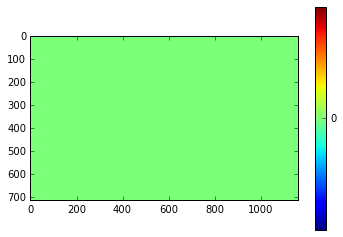

In [70]:
plt.figure()
#cm = np.array([[ 1,  1,  1 ], [ 1,0,0], [ 1,0,1], [ 0,1,0], [ 0,1,1], [ 0,0,1]])
#cmap = colors.ListedColormap(cm)
plt.imshow(train_img) #, cmap=cmap)
plt.colorbar(ticks=[0,1,2,3,4,5])

# Training data

In [65]:
def segment_features(segment_pixels):
    """For each band, compute: min, max, mean, variance, skewness, kurtosis"""
    features = []
    n_pixels, n_bands = segment_pixels.shape
    for b in range(n_bands):
        stats = scipy.stats.describe(segment_pixels[:,b])
        band_stats = list(stats.minmax) + list(stats)[2:]
        if n_pixels == 1:
            # scipy.stats.describe raises a Warning and sets variance to nan
            band_stats[3] = 0.0  # Replace nan with something (zero)
        features += band_stats
    return features

### Create all the objects:

In [66]:
# This is the most heavy part of the process. It could take about half an hour to finish in a not-so-fast CPU
import warnings


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    objects = []
    objects_ids = []
    for segment_label in segment_ids:
        segment_pixels = img[segments==segment_label]
        segment_model = segment_features(segment_pixels)
        objects.append(segment_model)
        # Keep a reference to the segment label
        objects_ids.append(segment_label)  

    print("Created %i objects" % len(objects))

Created 19121 objects


### Subset the training data

In [67]:
training_labels = []
training_objects = []
for klass in classes:
    class_train_objects = [v for i, v in enumerate(objects) if objects_ids[i] in segments_per_klass[klass]]
    training_labels += [klass] * len(class_train_objects)
    print("Training samples for class %i: %i" % (klass, len(class_train_objects)))
    training_objects += class_train_objects

# Train a classifier

In [68]:
classifier = RandomForestClassifier(n_jobs=-1)

In [69]:
classifier.fit(training_objects, training_labels)

/Users/allenbyron/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


ValueError: Found array with 0 feature(s) (shape=(1, 0)) while a minimum of 1 is required.

# Classify all segments

In [ ]:
predicted = classifier.predict(objects)

# Propagate the classification

In [ ]:
clf = np.copy(segments)

In [ ]:
for segment_id, klass in zip(objects_ids, predicted):
    clf[clf==segment_id] = klass

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(rgb_img, interpolation='none')
ax1.set_title('Original image')
ax2.imshow(clf, interpolation='none', cmap=colors.ListedColormap(np.random.rand(len(classes_labels), 3)))
ax2.set_title('Clasification')

# Classification validation¶


In [ ]:
shapefiles = [os.path.join(TEST_DATA_PATH, "%s.shp"%c) for c in classes_labels]
verification_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform, proj)
for_verification = np.nonzero(verification_pixels)

In [ ]:
verification_labels = verification_pixels[for_verification]
predicted_labels = clf[for_verification]

In [ ]:
cm = metrics.confusion_matrix(verification_labels, predicted_labels)

In [ ]:
def print_cm(cm, labels):
    """pretty print for confusion matrixes"""
    # https://gist.github.com/ClementC/acf8d5f21fd91c674808
    columnwidth = max([len(x) for x in labels])
    # Print header
    print(" " * columnwidth, end="\t")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end="\t")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("%{0}s".format(columnwidth) % label1, end="\t")
        for j in range(len(labels)):
            print("%{0}d".format(columnwidth) % cm[i, j], end="\t")
        print()

In [ ]:
print_cm(cm, classes_labels)

In [ ]:
print("Classification accuracy: %f" %
      metrics.accuracy_score(verification_labels, predicted_labels))

In [ ]:
print("Classification report:\n%s" %
      metrics.classification_report(verification_labels, predicted_labels,
                                    target_names=classes_labels))